In [1]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from train_utils import *
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
from copy import deepcopy

import uproot
from root_pandas import read_root


import socket
my_hostname=socket.gethostbyaddr(socket.gethostname())[0]
print('You are running on ', my_hostname)

Welcome to JupyROOT 6.22/02
You are running on  wudangshan


In [2]:
# Load the data

def load_data(debug=False):
    idir = '{}'.format('/nfs/user/pvischia/tth/dnn/' if 'cism.ucl.be' in my_hostname else './')
    file_tth = "{}/tree_2lss1tau.root".format(idir)
    key = "Friends"
    data_tth_orig = read_root(file_tth, key)
    if debug:
        data_tth_orig.describe()
    return data_tth_orig

In [3]:
# De-jag the data with respect to the jets

def dejag_data(data, debug=False):
    test=data['SelJet_pt']
    l = [len(i) for i in test]
    maxl = max(l)

    for lab in ['pt', 'eta', 'phi', 'mass', 'isBtag', 'isFromHadTop', 'btagDeepFlavB']:
        label='SelJet_%s'%lab
        tempLab=data[label]
        data.drop([label], axis=1, inplace=True)
        out = pd.DataFrame(tempLab.tolist(),columns=[ 'SelJet%s_%s'%(i, lab) for i in range(maxl)])
        data = pd.concat([data, out], axis=1)
    return data


In [4]:
# Remove ill-defined mass columns
def remove_masses(data, debug=False):
    for lab in data.columns:
        if 'mass' in lab:
            data.drop([lab], axis=1, inplace=True)
    return data

In [5]:
def load_feature_names(useJets=0, debug=False):
    thevars=[
            'Lep1_pt', 
            'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
             'nSelJets',
             'met', 'met_phi', 
             'HTT_score', 
             'Hj_tagger_hadTop',
             'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet',
             'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss',
             'dEtaBB_LLframe_2lss',
             'dEtaBB_2lss',
             'mTTH_2lss1tau',
             'theta_higgs_ttbar_TTHsystem_2lss1tau',
             'thetaTopTop_ttbarframe_2lss1tau', 
             'Tau_pt', 'Tau_eta', 'Tau_phi'
            ]
    if useJets>0:
        for i in range(useJets):
            thevars.append('SelJet%s_pt'%i)
            thevars.append('SelJet%s_eta'%i)
            thevars.append('SelJet%s_phi'%i)
            #thevars.append('SelJet%s_mass'%i)
            thevars.append('SelJet%s_isBtag'%i)
            thevars.append('SelJet%s_isFromHadTop'%i)
            thevars.append('SelJet%s_btagDeepFlavB'%i)
    if debug:
        print('Training features:', thevars)
        
    return thevars


In [6]:
def get_train_and_test(data, features, oddevensplit=False, fillna=False, debug=False):
    labs=deepcopy(features)
    if oddevensplit:
        labs.append('event')
    bkg = data[labs]
    sig = data[labs]

    if fillna:
        bkg.fillna(0, inplace=True)
        sig.fillna(0, inplace=True)


    wgtbkg=pd.DataFrame(data['weight_SM'].tolist(), columns=['weight'])
    wgtsig=pd.DataFrame(data['weight_CP_odd'].tolist(), columns=['weight'])

    labbkg = pd.DataFrame(np.zeros_like(bkg['Lep1_pt']).tolist(), columns=['label'])
    labsig = pd.DataFrame(np.ones_like(bkg['Lep1_pt']).tolist(), columns=['label'])

    bkg = pd.concat([bkg, wgtbkg, labbkg], axis=1)
    sig = pd.concat([sig, wgtsig, labsig], axis=1)

    sig['weight'] = sig['weight'].apply(lambda x: x if x <10. else 10.)

    labelled_set=pd.concat([sig, bkg], axis=0)
    if False:
        sns.pairplot(labelled_set, hue='label')
    if oddevensplit:
        labs.append('weight')
        X=labelled_set[labs]
        y=labelled_set['label']
        weight=labelled_set['weight']
        if debug:
            pd.set_option('display.max_columns', None)
            print(bkg.head())
            print(sig.head())

        X_wgt=X['weight']

        X_train=X[X['event']%2 == 0]
        X_test =X[X['event']%2 != 0]
        y_train=y[X['event']%2 == 0]
        y_test =y[X['event']%2 != 0]
        
        X_train_wgt=X_train['weight']
        X_train=X_train.drop(['weight'], axis=1, inplace=False)
        X_train=X_train.drop(['event'], axis=1, inplace=False)

        X_test_wgt=X_test['weight']
        X_test=X_test.drop(['weight'], axis=1, inplace=False)
        X_test=X_test.drop(['event'], axis=1, inplace=False)

        return {'X_train'     : X_train,
                'X_test'      : X_test, 
                'X_train_wgt' : X_train_wgt,
                'X_test_wgt'  : X_test_wgt,
                'y_train'     : y_train,
                'y_test'      : y_test 
               }
    else:
        labelled_set=shuffle(labelled_set)
        labs.append('weight')
        X=labelled_set[labs]
        y=labelled_set['label']
        weight=labelled_set['weight']
        if debug:
            pd.set_option('display.max_columns', None)
            print(bkg.head())
            print(sig.head())

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1534534, shuffle=True)

        X_train_wgt=X_train['weight']
        X_train=X_train.drop(['weight'], axis=1, inplace=False)
        X_test_wgt=X_test['weight']
        X_test=X_test.drop(['weight'], axis=1, inplace=False)

        return {'X_train'     : X_train,
                'X_test'      : X_test, 
                'X_train_wgt' : X_train_wgt,
                'X_test_wgt'  : X_test_wgt,
                'y_train'     : y_train,
                'y_test'      : y_test
               }
        #train_dmatrix = xgb.DMatrix(data=X_train,label=y_train,weight=X_train_wgt)
        #test_dmatrix = xgb.DMatrix(data=X_test,label=y_test,weight=X_test_wgt)

    #perm = np.random.permutation(len(X_train))
    #X_train = X_train[perm]
    #y_train = y_train[perm]
    #X_train_wgt = X_train_wgt[perm]

    #perm = np.random.permutation(len(X_train))
    #X_test = X_test[perm]
    #y_test = y_test[perm]
    #X_test_wgt = X_test_wgt[perm]


In [7]:
def plot_features(X, y, wgt, features, label):
    fix, axs= plt.subplots(10,10, figsize=(40,40))
    axs = axs.ravel()

    for i,ax in enumerate(axs):
        if i >= len(features):
            continue
        var=features[i]
        if var=='weight':
            continue
        ax=axs[i]
        #ax.hist(X_train[var], label='%s'%var)
        ax.hist(X[var][y[:]==0 ], weights=wgt[y[:]==0 ], density=True, alpha=0.5, bins=20)
        ax.hist(X[var][y[:]==1 ], weights=wgt[y[:]==1 ], density=True, alpha=0.5, bins=20)
        #ax.set_yscale('log')
        ax.set_title('%s dataset'%label)
        ax.set_xlabel(var)
    plt.show()
    plt.hist(wgt[y[:]==0 ], alpha=0.5, bins=np.linspace(0,20,200))
    plt.yscale("log")
    plt.hist(wgt[y[:]==1 ], alpha=0.5, bins=np.linspace(0,20,200))
    plt.title('%s dataset')
    plt.show()

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)


In [8]:
# Load the data
debug=False
data_tth_orig = load_data(debug=debug)
data_tth=data_tth_orig # save the original
data_tth=dejag_data(data_tth, debug=debug)
data_tth=remove_masses(data_tth, debug=debug)
    
the_initial_vars=load_feature_names(useJets=0, debug=debug) # add "useJets" quadrimomenta of jets


In [9]:
# Train a single model (the basic template)

def train_single_model(data, features, oddevensplit=True, fillna=False, debug=False):
    # Start with a first thing with all variables
    datasets= get_train_and_test(data, features, oddevensplit=oddevensplit, fillna=fillna, debug=debug)
    X_train     = datasets['X_train']
    X_test      = datasets['X_test']
    X_train_wgt = datasets['X_train_wgt']
    X_test_wgt  = datasets['X_test_wgt']
    y_train     = datasets['y_train']
    y_test      = datasets['y_test']

    if debug:
        plot_features(X_train, y_train, X_train_wgt, the_initial_vars, 'training')
        plot_features(X_test , y_test , X_test_wgt , the_initial_vars, 'test')
    # WORKING PROTOTYPE: xg_class = xgb.XGBClassifier(n_estimators=120, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=1)
    xg_class = xgb.XGBClassifier(n_estimators=120, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=1, gamma=1)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xg_class.fit(X=X_train,y=y_train,eval_metric=["error", "logloss"], early_stopping_rounds=10, eval_set=eval_set,sample_weight=X_train_wgt,sample_weight_eval_set=[X_train_wgt, X_test_wgt])

    preds_train = xg_class.predict_proba(X_train)[:,0]
    preds_test = xg_class.predict_proba(X_test)[:,0]

    #preds_train=np.argmax(xg_class.predict_proba(X_train), axis=1)
    #preds_test =np.argmax(xg_class.predict_proba(X_test), axis=1)

    preds_cat_train = xg_class.predict(X_train)
    preds_cat_test  = xg_class.predict(X_test)
    # ROC curves
    auc_train=plot_roc(y_train, preds_train, sample_weight=X_train_wgt, label='training', plot=False, debug=False)
    auc_test=plot_roc(y_test, preds_test, sample_weight=X_test_wgt, label='test', plot=False, debug=False)

    xgb.plot_importance(xg_class)
    plt.figure(figsize = (16, 12))
    plt.show()
    accuracy_train = accuracy_score(y_train, preds_cat_train,sample_weight=X_train_wgt)
    print("Accuracy (train): %.2f%%" % (accuracy_train * 100.0))
    accuracy_test = accuracy_score(y_test, preds_cat_test, sample_weight=X_test_wgt)
    print("Accuracy (test): %.2f%%" % (accuracy_test * 100.0))

    if debug:
        results = xg_class.evals_result()
        epochs = len(results['validation_0']['logloss'])
        x_axis = range(0, epochs)
        # plot log loss
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
        ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
        ax.legend()
        plt.ylabel('Log Loss')
        plt.title('XGBoost Log Loss')
        plt.show()
        # plot classification error
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0']['error'], label='Train')
        ax.plot(x_axis, results['validation_1']['error'], label='Test')
        ax.legend()
        plt.ylabel('Classification Error')
        plt.title('XGBoost Classification Error')
        plt.show()

        cm = confusion_matrix(y_test, preds_cat_test, sample_weight=X_test_wgt)
        plot_confusion_matrix(cm, ['CP odd', 'CP even'])
        plot_rel_pred(y_test, preds_test, 'test')
        plot_pred(y_test, preds_test, 'test')
        plot_weights(X_test_wgt, y_test, 'test')
        
    return {'auc_train': auc_train, 'auc_test': auc_test, 'model': xg_class, 'features': features}

[0]	validation_0-error:0.17432	validation_0-logloss:0.65071	validation_1-error:0.17777	validation_1-logloss:0.65137
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17394	validation_0-logloss:0.61644	validation_1-error:0.17761	validation_1-logloss:0.61760
[2]	validation_0-error:0.17432	validation_0-logloss:0.58813	validation_1-error:0.17732	validation_1-logloss:0.58974
[3]	validation_0-error:0.17477	validation_0-logloss:0.56451	validation_1-error:0.17720	validation_1-logloss:0.56673
[4]	validation_0-error:0.17443	validation_0-logloss:0.54476	validation_1-error:0.17718	validation_1-logloss:0.54760
[5]	validation_0-error:0.17443	validation_0-logloss:0.52830	validation_1-error:0.17714	validation_1-logloss:0.53169
[6]	validation_0-error:0.17443	validation_0-logloss:0.51454	validation_1-error:0.17714	validation_1-logloss:0.51847
[7]	validation_0-error:

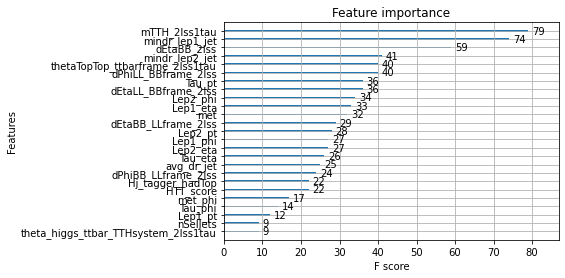

<Figure size 1152x864 with 0 Axes>

Accuracy (train): 82.84%
Accuracy (test): 82.27%
AUC train: 0.6904603179084736
AUC test: 0.6904603179084736
Variable importance {'dEtaBB_2lss': 59, 'mTTH_2lss1tau': 79, 'Lep2_eta': 27, 'mindr_lep1_jet': 74, 'met': 32, 'dPhiLL_BBframe_2lss': 40, 'Lep1_eta': 33, 'dEtaLL_BBframe_2lss': 36, 'mindr_lep2_jet': 41, 'Tau_phi': 14, 'met_phi': 17, 'dEtaBB_LLframe_2lss': 29, 'Lep2_phi': 34, 'thetaTopTop_ttbarframe_2lss1tau': 40, 'Tau_pt': 36, 'Lep2_pt': 28, 'dPhiBB_LLframe_2lss': 24, 'Tau_eta': 26, 'Lep1_pt': 12, 'theta_higgs_ttbar_TTHsystem_2lss1tau': 9, 'Lep1_phi': 27, 'HTT_score': 22, 'Hj_tagger_hadTop': 22, 'nSelJets': 9, 'avg_dr_jet': 25}


In [13]:
train_res= train_single_model(data_tth, the_initial_vars, oddevensplit=True, fillna=False, debug=False)

print('AUC train:', train_res['auc_train'])
print('AUC test:', train_res['auc_train'])
print('Variable importance', train_res['model'].get_booster().get_score(importance_type='weight'))



In [ ]:
# Save the best model

convert_model(model,input_variables=input_vars,output_xml=os.path.join(save_dir,'xgboost-{}.xml'.format(channel)))